In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import json
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor  

palette = "rainbow_r"

In [2]:
df = pd.read_csv('TA_restaurants_curated.csv', index_col='Unnamed: 0')
df.head()

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [3]:
df = df[['Name', 'City', 'Cuisine Style', 'Ranking', 'Rating', 'Price Range']]
df.loc[df['City'] == 'Oporto', 'City'] = 'Porto'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125527 entries, 0 to 1666
Data columns (total 6 columns):
Name             125527 non-null object
City             125527 non-null object
Cuisine Style    94176 non-null object
Ranking          115876 non-null float64
Rating           115897 non-null float64
Price Range      77672 non-null object
dtypes: float64(2), object(4)
memory usage: 6.7+ MB


In [4]:
geoloc = pd.read_csv('worldcities.csv', index_col=None)
more_cities = pd.DataFrame([{'city': 'Zurich', 'lat':47.3769, 'lng':8.5417, 'country':'Switzerland'}, 
                            {'city': 'Krakow', 'lat':50.0647, 'lng':19.9450, 'country':'Poland'}])
geoloc = pd.concat([geoloc, more_cities], sort=True)

In [5]:
cities = list(np.unique(df['City'].values))
for c in cities:
    try:
        df.loc[df['City'] == c, 'Latitude'] = geoloc.loc[geoloc.city == c]['lat'].values[0]
        df.loc[df['City'] == c, 'Longitude'] = geoloc.loc[geoloc.city == c]['lng'].values[0]
        df.loc[df['City'] == c, 'Country'] = geoloc.loc[geoloc.city == c]['country'].values[0]
    except:
        pass
    
df.head()

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Latitude,Longitude,Country
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,52.35,4.9166,Netherlands
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,52.35,4.9166,Netherlands
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,52.35,4.9166,Netherlands
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,52.35,4.9166,Netherlands
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,52.35,4.9166,Netherlands


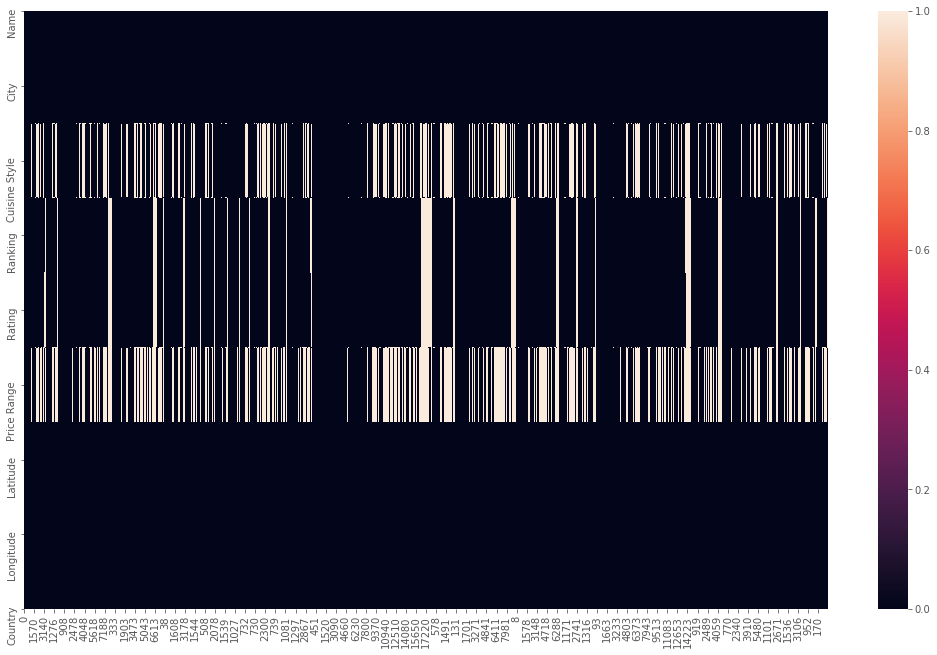

In [6]:
fig, ax = plt.subplots(figsize=(18, 11))
sns.heatmap(df.isnull().transpose())

In [7]:
df = df.dropna(axis='index', how='all')
df = df.dropna(axis='index', subset=['Cuisine Style'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94176 entries, 0 to 1666
Data columns (total 9 columns):
Name             94176 non-null object
City             94176 non-null object
Cuisine Style    94176 non-null object
Ranking          89063 non-null float64
Rating           89049 non-null float64
Price Range      77672 non-null object
Latitude         94176 non-null float64
Longitude        94176 non-null float64
Country          94176 non-null object
dtypes: float64(4), object(5)
memory usage: 7.2+ MB


In [8]:
# df['Rating'] = df['Rating'].interpolate().astype(int)
# df = df[df['Rating'] >= 0]
# list(np.unique(np.array([x for x in df['Rating'].values if x != np.nan])))

In [9]:
df['Ranking'] = df['Ranking'].fillna(df['Ranking'].max()+1)

In [10]:
#Binarizing 'Cuisine Style' column
styles = set()
for list1 in df['Cuisine Style'].values:
    try:
        styles = styles.union({s.replace("'", "") for s in  list1.strip('][').split(', ')})
    except:
        pass
    
styles = sorted(list(styles))
df_cs =  df[['Name','City']].copy()
for style in styles:
    df_cs[style] = df['Cuisine Style'].str.contains("'{}'".format(style), na=False, regex=False)
    df_cs.loc[df_cs[style] == False, style] = 0
    df_cs.loc[df_cs[style] == True, style] = 1

In [11]:
df['Number of styles'] = df_cs[styles].sum(axis=1)
df_cs['Number of styles'] = df_cs[styles].sum(axis=1)
df.drop(['Cuisine Style'], axis=1, inplace=True)

In [12]:
#Cleaning Price Range
prange_dict = {1:'$', 2:'$$ - $$$', 3:'$$$$'}
for k, v in prange_dict.items():
    df.loc[df['Price Range'] == v, 'Price Range'] = k
    
df['Price Range'] = df['Price Range'].fillna(0)

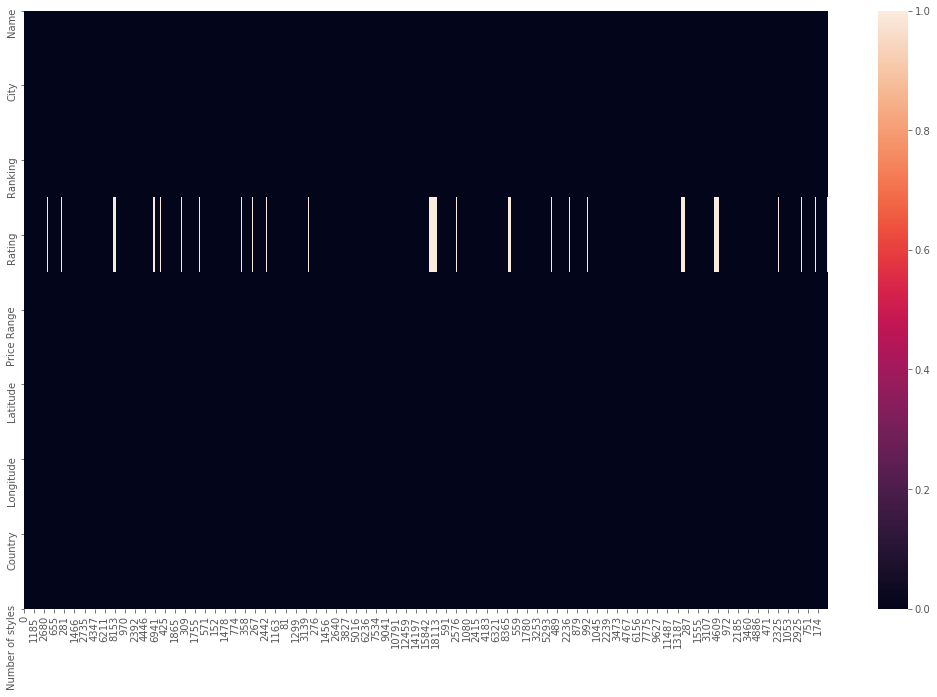

In [13]:
fig, ax = plt.subplots(figsize=(18, 11))
sns.heatmap(df.isnull().transpose())

In [14]:
#Imputing Rating column
target_feat = 'Rating'

df[target_feat] = df[target_feat].astype(str)
df[target_feat] = df[target_feat].fillna('nan')

features = list(df.columns)
for x in [target_feat, 'Name', 'City', 'Country', 'Ranking']:
    features.remove(x)

df_train = df[df[target_feat] != 'nan']
df_test  = df[df[target_feat] == 'nan']

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(df_train[features].values, df_train[target_feat].values)
df_test[target_feat] = knn_classifier.predict(df_test[features].values)
df = pd.concat([df_train, df_test])
df[target_feat] = df[target_feat].astype(np.float64)
df

C:\Users\Zouheir\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Name,City,Ranking,Rating,Price Range,Latitude,Longitude,Country,Number of styles
0,Martine of Martine's Table,Amsterdam,1.0,5.0,2,52.3500,4.9166,Netherlands,3.0
1,De Silveren Spiegel,Amsterdam,2.0,4.5,3,52.3500,4.9166,Netherlands,4.0
2,La Rive,Amsterdam,3.0,4.5,3,52.3500,4.9166,Netherlands,6.0
3,Vinkeles,Amsterdam,4.0,5.0,3,52.3500,4.9166,Netherlands,7.0
4,Librije's Zusje Amsterdam,Amsterdam,5.0,4.5,3,52.3500,4.9166,Netherlands,6.0
...,...,...,...,...,...,...,...,...,...
1660,Da Toto,Zurich,16444.0,4.0,2,47.3769,8.5417,Switzerland,1.0
1661,RAW by Michael Adams,Zurich,16444.0,4.0,2,47.3769,8.5417,Switzerland,4.0
1663,Blueberry American Bakery,Zurich,16444.0,4.5,0,47.3769,8.5417,Switzerland,1.0
1665,Yoyo Pizza,Zurich,16444.0,4.5,0,47.3769,8.5417,Switzerland,1.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94176 entries, 0 to 1666
Data columns (total 9 columns):
Name                94176 non-null object
City                94176 non-null object
Ranking             94176 non-null float64
Rating              94176 non-null float64
Price Range         94176 non-null int64
Latitude            94176 non-null float64
Longitude           94176 non-null float64
Country             94176 non-null object
Number of styles    94176 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 7.2+ MB


# Data analysis

In [16]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df.copy().drop(['Name', 'Country', 'City', 'Rating'], axis=1).values)
df['Cluster ID'] = kmeans.labels_

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94176 entries, 0 to 1666
Data columns (total 10 columns):
Name                94176 non-null object
City                94176 non-null object
Ranking             94176 non-null float64
Rating              94176 non-null float64
Price Range         94176 non-null int64
Latitude            94176 non-null float64
Longitude           94176 non-null float64
Country             94176 non-null object
Number of styles    94176 non-null float64
Cluster ID          94176 non-null int32
dtypes: float64(5), int32(1), int64(1), object(3)
memory usage: 7.5+ MB


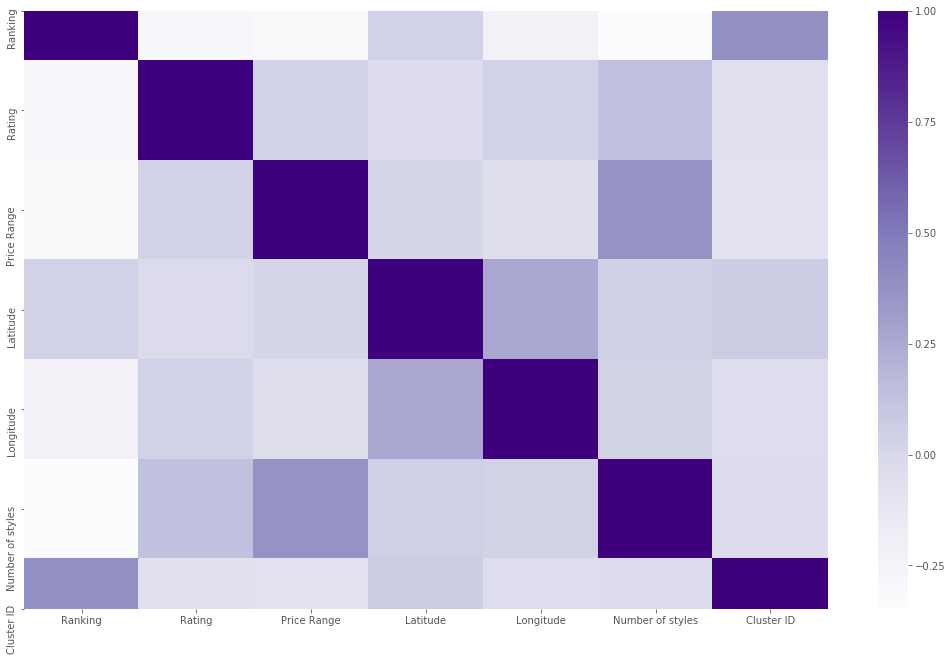

In [18]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(18, 11))
sns.heatmap(df_corr, ax=ax, cmap='Purples')

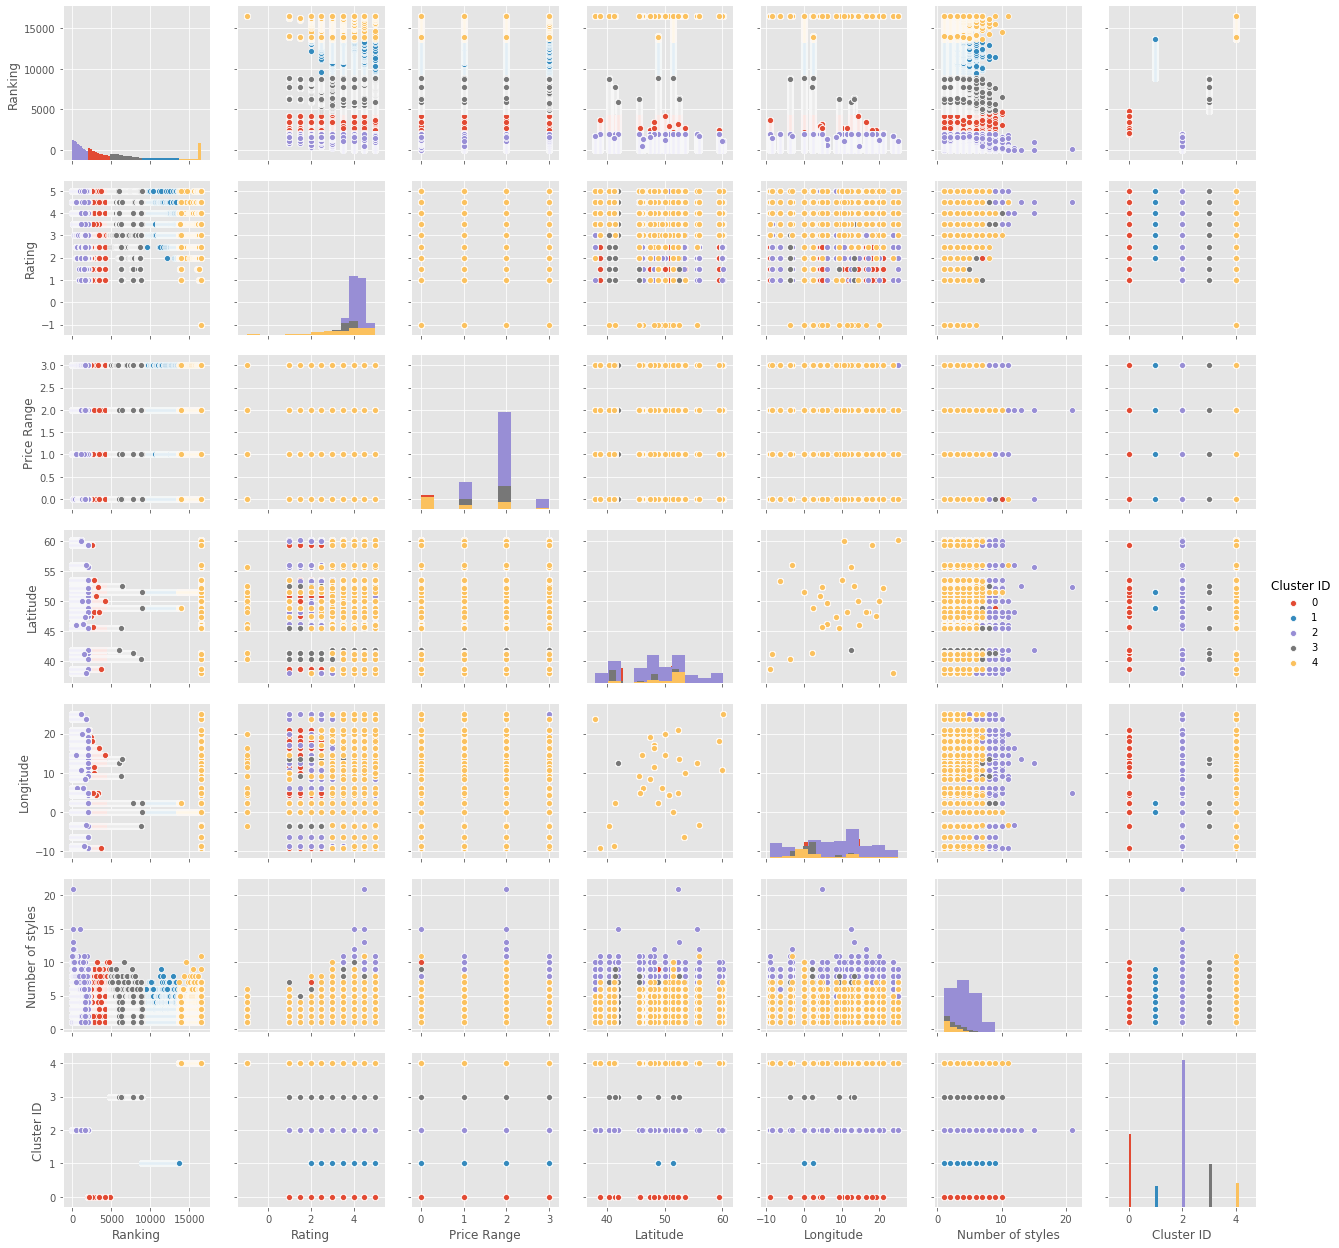

In [19]:
city_features = [x for x in df.columns if x not in ['Cluster ID', 'City']]
sns.pairplot(df, 
             diag_kind='hist', 
             hue='Cluster ID')

# Analysis by city

In [20]:
df_city = df.groupby('City').mean()
df_city['Restaurant Count'] = df.groupby('City').count()['Name']
df_city['Number of styles'] = df_cs.groupby('City').max()[styles].sum(axis=1)
df_city['Price Range'] = df.groupby('City').median()['Price Range']
df_city['Cluster ID'] = df.groupby('City').median()['Cluster ID'].astype(int)
df_city.index.name = None
df_city['City'] = df_city.index
df_city

,Ranking,Rating,Price Range,Latitude,Longitude,Number of styles,Cluster ID,Restaurant Count,City
Amsterdam,2212.531768,4.101174,2,52.3500,4.9166,97,2,2896,Amsterdam
Athens,1794.125651,4.249674,2,37.9833,23.7333,78,2,1536,Athens
Barcelona,4234.037101,3.986459,2,41.3833,2.1834,105,2,6388,Barcelona
Berlin,3656.845336,4.097072,2,52.5218,13.4015,109,2,4610,Berlin
Bratislava,2256.625194,4.063764,2,48.1500,17.1170,72,2,643,Bratislava
Brussels,2143.195379,3.896636,2,50.8333,4.3333,90,2,2467,Brussels
Budapest,2018.053733,4.110556,2,47.5000,19.0833,92,2,2103,Budapest
Copenhagen,1827.518589,3.972275,2,55.6786,12.5635,90,2,1587,Copenhagen
Dublin,1581.827089,4.058790,2,53.3331,-6.2489,87,2,1735,Dublin
Edinburgh,1360.733750,4.075938,2,55.9483,-3.2191,81,2,1600,Edinburgh


In [21]:
df_city.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, Amsterdam to Zurich
Data columns (total 9 columns):
Ranking             31 non-null float64
Rating              31 non-null float64
Price Range         31 non-null int64
Latitude            31 non-null float64
Longitude           31 non-null float64
Number of styles    31 non-null int64
Cluster ID          31 non-null int32
Restaurant Count    31 non-null int64
City                31 non-null object
dtypes: float64(4), int32(1), int64(3), object(1)
memory usage: 2.3+ KB


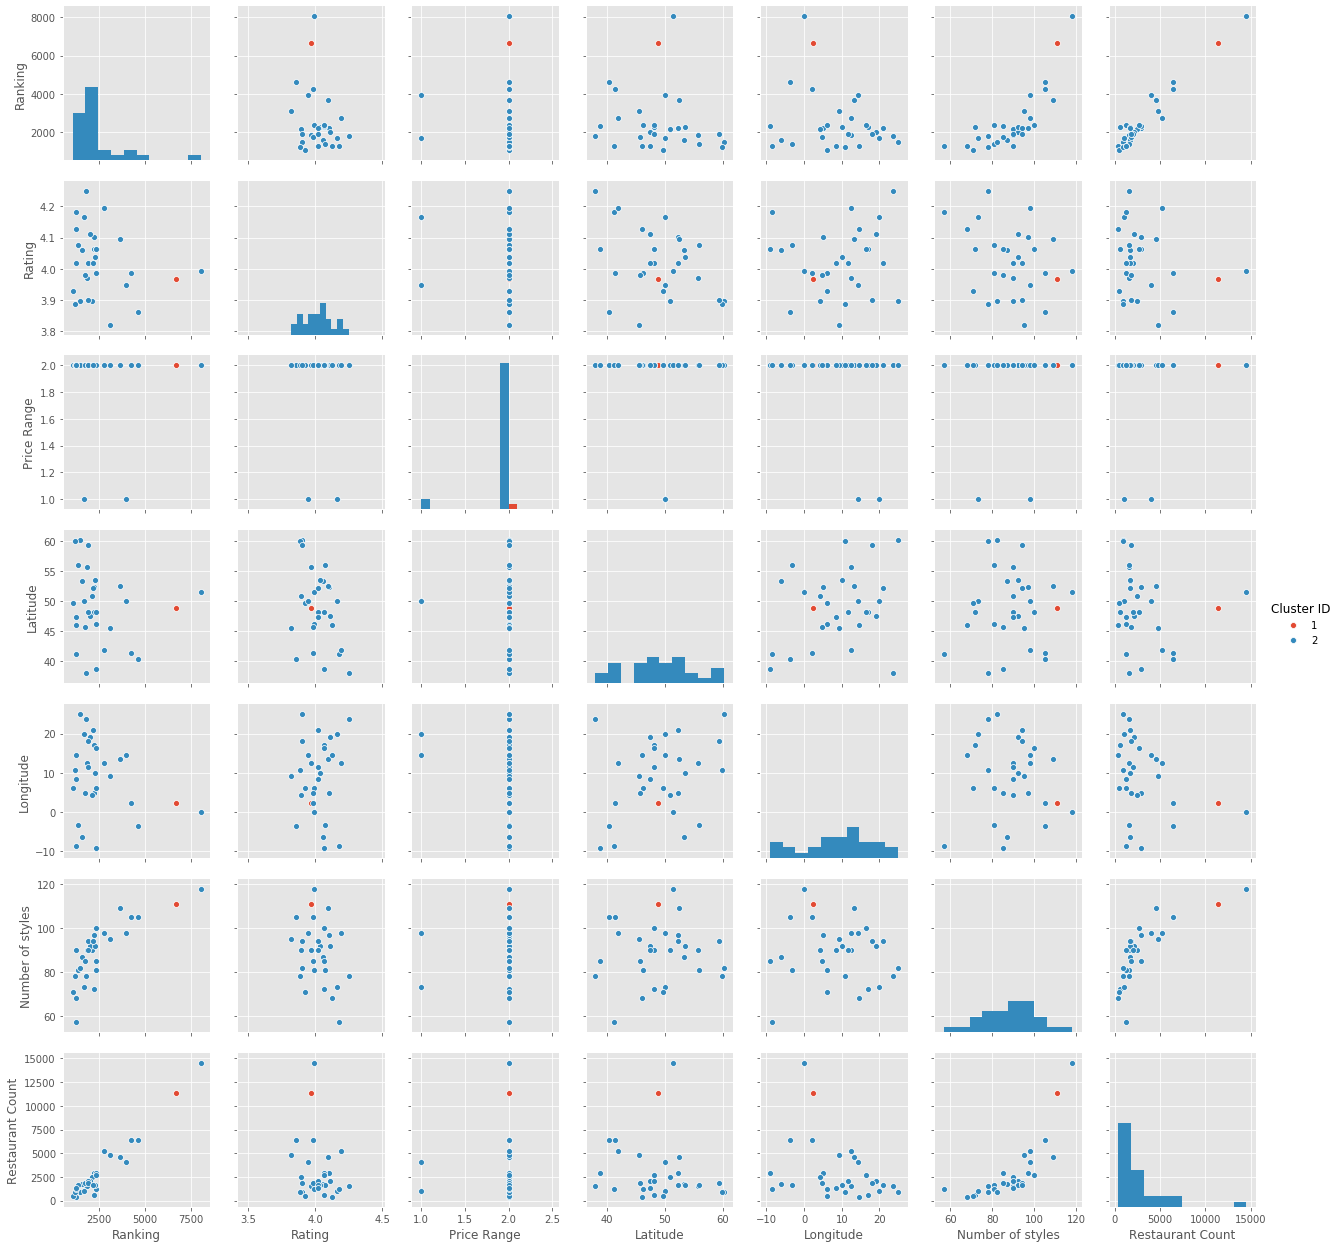

In [22]:
city_features = [x for x in df_city.columns if x not in ['Cluster ID', 'City']]
sns.pairplot(df_city, 
             vars=city_features, 
             diag_kind='hist', 
             hue='Cluster ID')

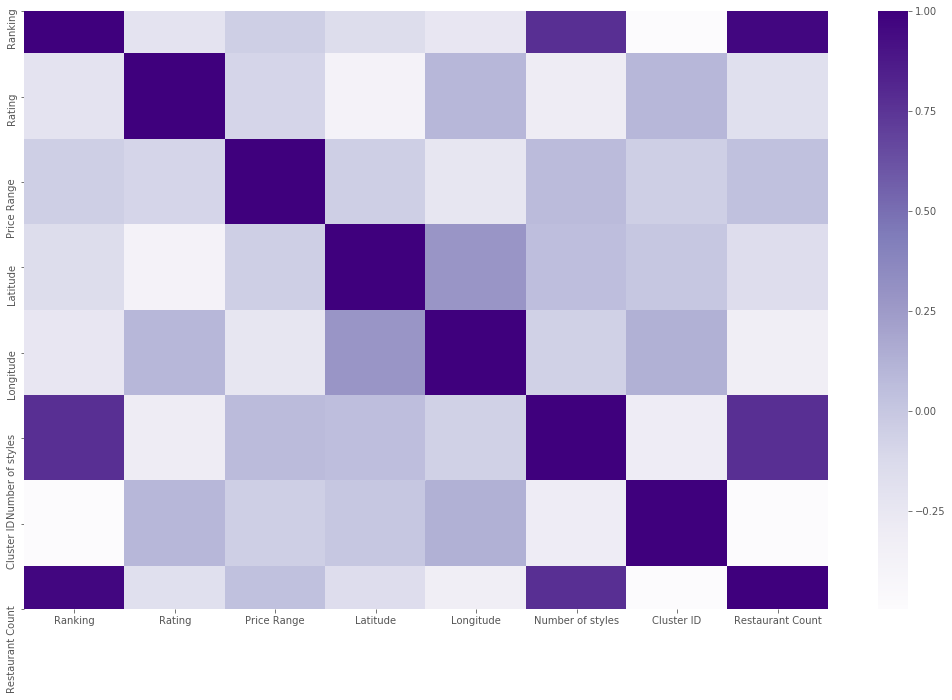

In [23]:
df_city_corr = df_city.corr()
fig, ax = plt.subplots(figsize=(18, 11))
sns.heatmap(df_city_corr, ax=ax, cmap='Purples')

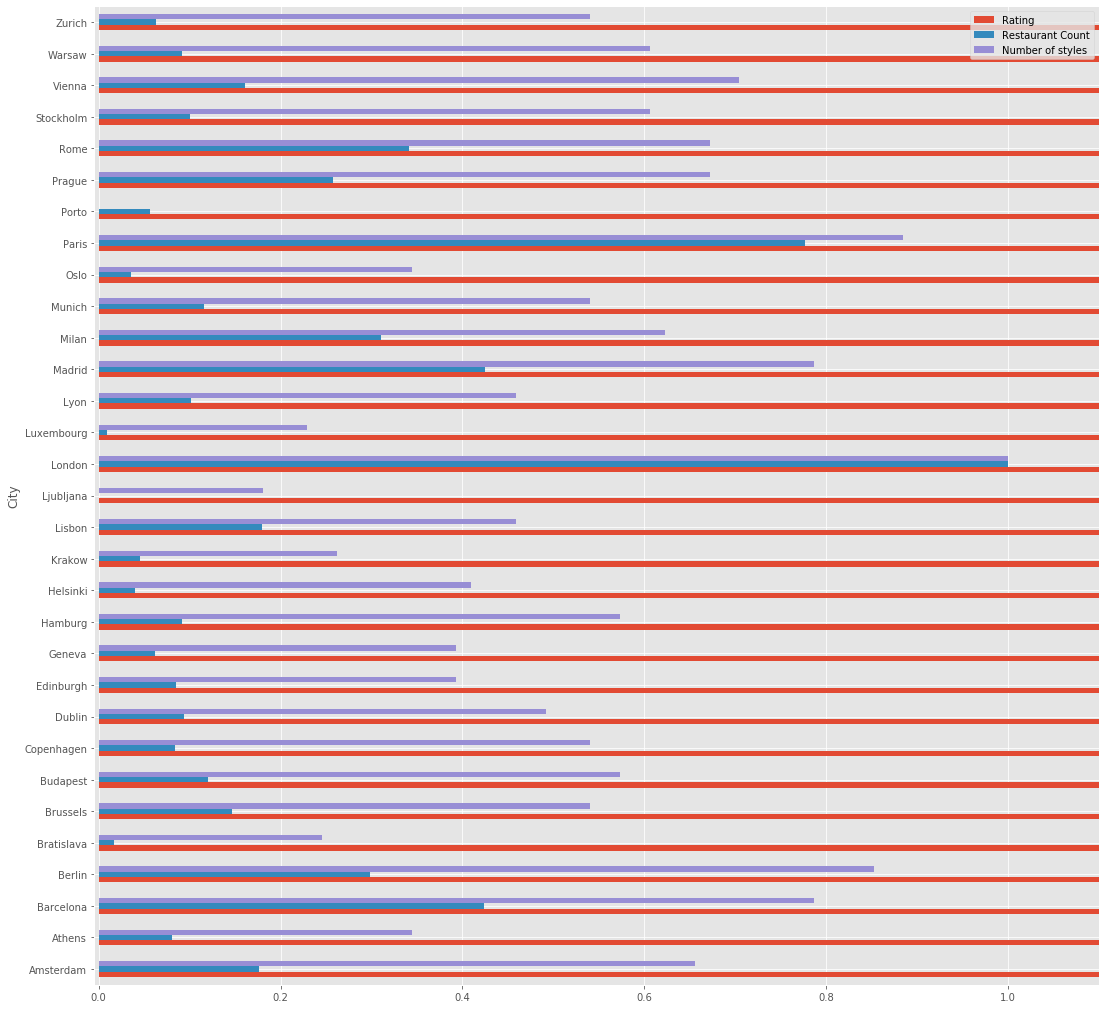

In [24]:
df_city_normalized = df_city.copy()
df_city_normalized['Restaurant Count'] = (df_city['Restaurant Count'] - df_city['Restaurant Count'].min())/(df_city['Restaurant Count'].max() - df_city['Restaurant Count'].min())
df_city_normalized['Number of styles'] = (df_city['Number of styles'] - df_city['Number of styles'].min())/(df_city['Number of styles'].max() - df_city['Number of styles'].min())
# df_city_normalized['Rating'] = (df_city['Rating'] - df_city['Rating'].min())/(df_city['Rating'].max() - df_city['Rating'].min())

ax = df_city_normalized.plot.barh(x='City', y=['Rating','Restaurant Count', 'Number of styles'], figsize=(18, 18))
ax.set_xlim([-0.005, 1.1])
ax = ax.set_yticklabels(df_city_normalized.index)

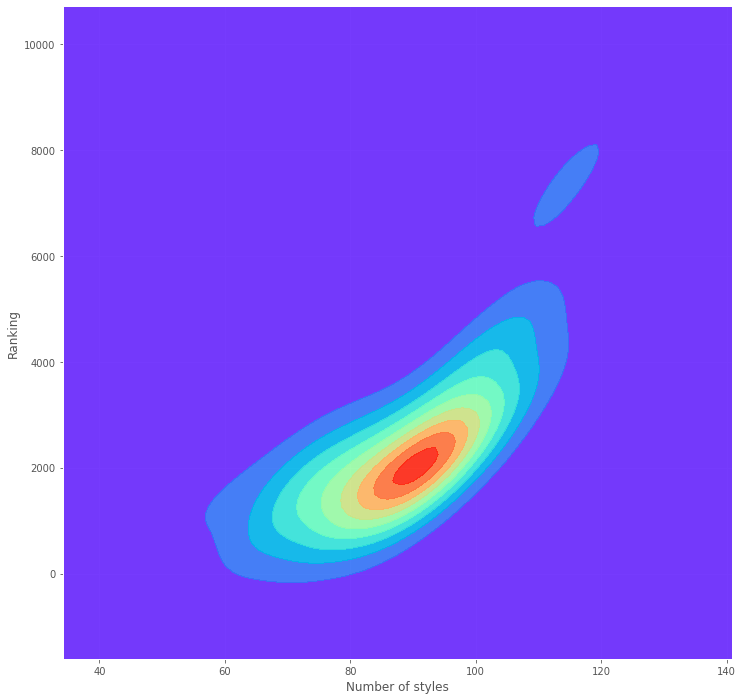

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(df_city['Number of styles'], df_city['Ranking'], shade=True, alpha=0.9, ax=ax, cmap='rainbow')

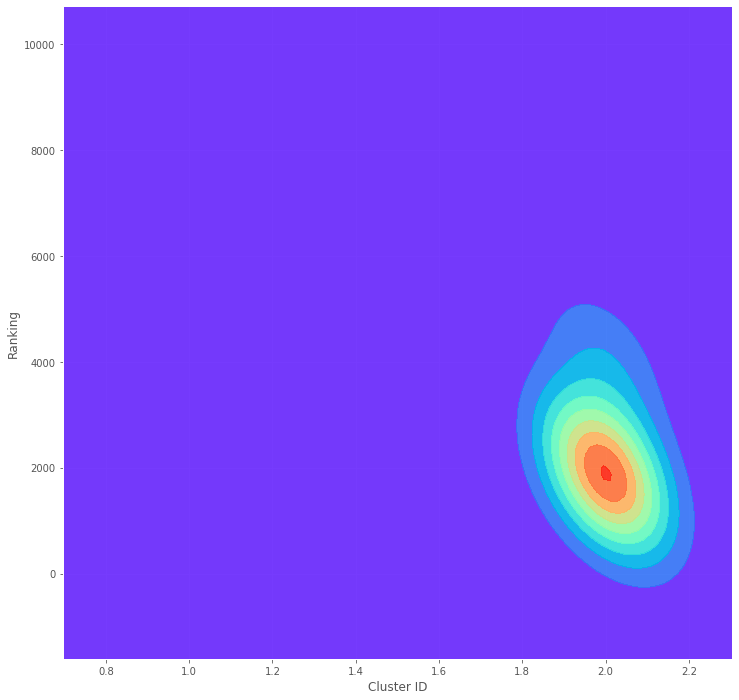

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(df_city['Cluster ID'], df_city['Ranking'], shade=True, alpha=0.9, ax=ax, cmap='rainbow')

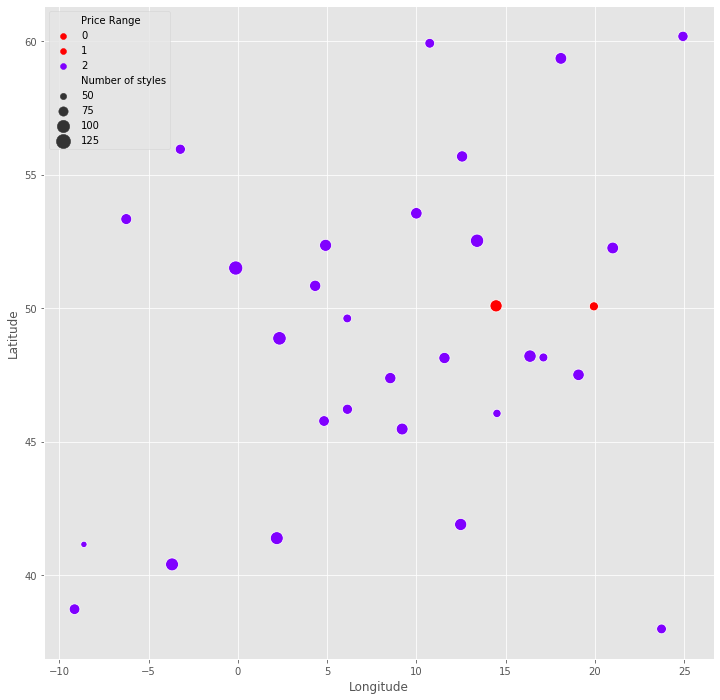

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x="Longitude", y="Latitude", data=df_city, 
                size="Number of styles", hue="Price Range", 
                sizes=(40,200), palette=palette, ax=ax)

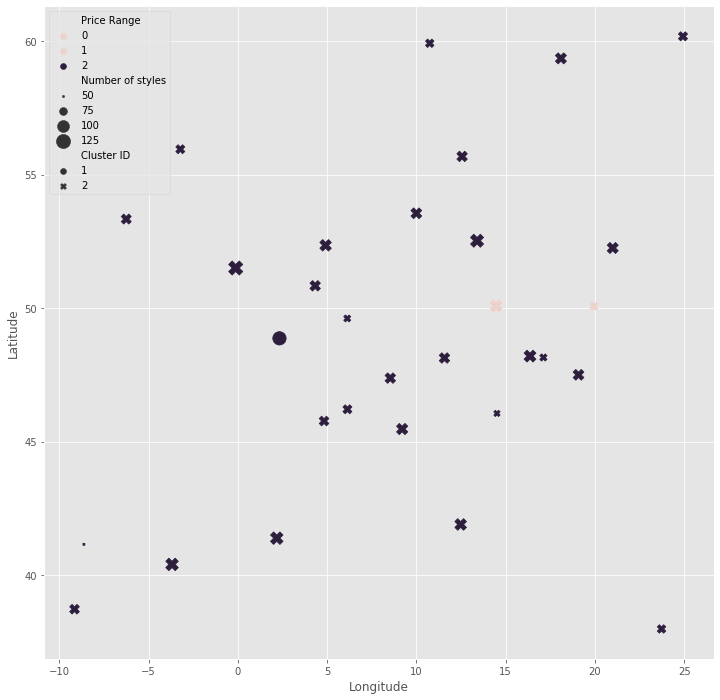

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x="Longitude", y="Latitude", data=df_city, 
                size="Number of styles", hue="Price Range", style="Cluster ID", palette="Greens",
                sizes=(5,200), ax=ax, edgecolor=None)